In [1]:
import itertools
import os
import subprocess
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep

parent_dir = Path(os.path.abspath("RunGPUSimulation2.ipynb")).parent.parent
sys.path.append(str(parent_dir))
from src.annealing_depth import plot_data_vs_sim

In [2]:
plt.style.use(hep.style.ROOT)

In [3]:
!nvidia-smi
!nvcc  -o radicals -x cu -lnvToolsExt -I ../CLI11/include ../src/solverRadicals.cu

Tue Jul 18 06:20:06 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-12GB            Off| 00000000:65:00.0 Off |                    0 |
| N/A   45C    P0               33W / 250W|    462MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
!./radicals -h

Radical diffusion simulation
Usage: ./radicals [OPTIONS]

Options:
  -h,--help                   Print this help message and exit
  --diffCoeff FLOAT           Diffusion coefficient
  --radFormRate FLOAT         Radical formation rate
  --k1 FLOAT                  Rate of crosslinking
  --k2 FLOAT                  Rate of radical oxidation
  --doseRate FLOAT            Dose rate
  --irrTime INT               Irradiation time
  --totalTime INT             Total time
  --dimXYZ INT x 3            Dimensions X Y Z of the array
  --outputPrefix TEXT         Output file name
  -l,--limitedSave            Save only the middle slice for activity


In [5]:
def run_sim(D, R, k1, k2):
    """
    Run the simulation with the given parameters and save the maximum of
    the activity as function of time as a numpy array.

    Parameters
    ----------
    D : float
        Diffusion coefficient
    R : float
        Radical formation rate (includes the dose rate so it's Y*R)
    k1 : float
        Rate constant for the radical crosslinking reaction
    k2 : float
        Rate constant for the radical oxidation reaction

    Returns
    -------
    None
    """
    print(f"Processing D={D} R={R} k1={k1} k2={k2}")
    subprocess.run(
        [
            "./radicals",
            "--diffCoeff",
            str(D),
            "--radFormRate",
            str(R),
            "--k1",
            str(k1),
            "--k2",
            str(k2),
            "-l",
        ],
    )
    activity = np.fromfile("outputactivity.dat", dtype=np.float32)
    tDim = 20000
    xDim = 100
    activity = np.reshape(activity, (tDim, xDim))
    maximum = []
    times = range(10001, 20000)
    for time in times:
        maximum.append(np.argmax(activity[time, :]))
    times = np.array(times)
    times = times - times[0]
    maximum = np.array(maximum)
    maximum = maximum / 10
    label = f"D_{D}_R_{R}_k1_{k1}_k2_{k2}".replace(".", "p")
    np.save(f"../data/sim_{label}", maximum)

In [46]:
D = 0.01
R_arr = [0.0003, 0.00045, 0.0006]
k1_arr = [0.01, 0.02, 0.03]
k2_arr = [0.05, 0.1, 0.2]
for R, k1, k2 in itertools.product(R_arr, k1_arr, k2_arr):
    run_sim(D, R, k1, k2)

Processing D=0.01 R=0.0003 k1=0.01 k2=0.05
Processing D=0.01 R=0.0003 k1=0.01 k2=0.1
Processing D=0.01 R=0.0003 k1=0.01 k2=0.2
Processing D=0.01 R=0.0003 k1=0.02 k2=0.05
Processing D=0.01 R=0.0003 k1=0.02 k2=0.1
Processing D=0.01 R=0.0003 k1=0.02 k2=0.2
Processing D=0.01 R=0.0003 k1=0.03 k2=0.05
Processing D=0.01 R=0.0003 k1=0.03 k2=0.1
Processing D=0.01 R=0.0003 k1=0.03 k2=0.2
Processing D=0.01 R=0.00045 k1=0.01 k2=0.05
Processing D=0.01 R=0.00045 k1=0.01 k2=0.1
Processing D=0.01 R=0.00045 k1=0.01 k2=0.2
Processing D=0.01 R=0.00045 k1=0.02 k2=0.05
Processing D=0.01 R=0.00045 k1=0.02 k2=0.1
Processing D=0.01 R=0.00045 k1=0.02 k2=0.2
Processing D=0.01 R=0.00045 k1=0.03 k2=0.05
Processing D=0.01 R=0.00045 k1=0.03 k2=0.1
Processing D=0.01 R=0.00045 k1=0.03 k2=0.2
Processing D=0.01 R=0.0006 k1=0.01 k2=0.05
Processing D=0.01 R=0.0006 k1=0.01 k2=0.1
Processing D=0.01 R=0.0006 k1=0.01 k2=0.2
Processing D=0.01 R=0.0006 k1=0.02 k2=0.05
Processing D=0.01 R=0.0006 k1=0.02 k2=0.1
Processing D=0.01

In [42]:
def plot_sim(D, R, k1, k2, ax, mode=None):
    """
    Plot the simulation results and the experimental data.

    Parameters
    ----------
    D : float
        Diffusion coefficient
    R : float
        Radical formation rate (includes the dose rate so it's Y*R)
    k1 : float
        Rate constant for the radical crosslinking reaction
    k2 : float
        Rate constant for the radical oxidation reaction
    mode: str
        The running mode:
         - "scan" mode will print the chi square and the parameters
         - "paper" mode will add the fit to the plot

    Returns
    -------
    None
    """
    filename = f"D_{D}_R_{R}_k1_{k1}_k2_{k2}".replace(".", "p")
    if mode == "scan":
        label = f"R={R} k1={k1} k2={k2}"
    else:
        label = "color depth simulation"
    maximum = np.load(f"../data/sim_{filename}.npy")

    times = np.linspace(0, 9999, 9999)

    # find the saturation point
    # t_saturation = times[np.argmax(maximum)]

    # Days to a.u.
    # times = times * 0.85 / t_saturation

    ax.plot(times, maximum, label=label)

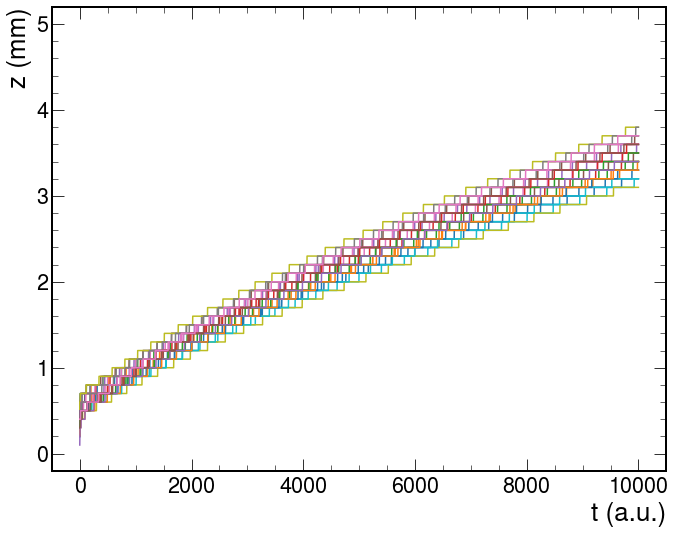

In [45]:
fig, ax = plt.subplots(figsize=(10, 8))
D = 0.01
R_arr = [0.0003, 0.00045, 0.0006]
k1_arr = [0.01, 0.02, 0.03]
k2_arr = [0.05, 0.1, 0.2]
for R, k1, k2 in itertools.product(R_arr, k1_arr, k2_arr):
    plot_sim(D, R, k1, k2, ax)
ax.set_xlim(-500, 10500)
ax.set_ylim(-0.2, 5.2)
ax.set_xlabel("t (a.u.)")
ax.set_ylabel("z (mm)")
fig.tight_layout()
plt.show()